# Introduction

In our interconnected world, financial stability and responsible money management are vital. A key element in evaluating the financial health of an individual is the credit score. The credit score significantly impacts prospects when you apply for a loan, rent an apartment, or seek employment. Understanding credit score classification is crucial for financial services companies to make informed decisions regarding lending, providing guarantees, etc.

Businesses, banks, governments, insurance companies, and car companies are interested in knowing an individual's credit score because it provides them with a quick assessment of the person's creditworthiness.

A credit score is a numerical representation of an individual's credit history and helps these entities evaluate the likelihood of the person repaying their debts or fulfilling their financial obligations.

A good credit score indicates that an individual has a history of responsibly managing their debts. Lenders, such as banks and financial institutions, use credit scores to assess the risk involved in lending money. A higher credit score increases the chances of obtaining loans at favourable terms, such as lower interest rates.

Companies, banks, and financial institutions can leverage credit score data and analysis to help customers gain a better understanding of how certain factors, such as delayed payments or outstanding debt, impact their credit score. By utilizing this information, they can effectively educate customers on the significance of these features and how they contribute to their overall creditworthiness.

We have selected the "Credit Score Classification" dataset, obtained from Kaggle.com and created by Paris Rohan[1]. This dataset offers a range of columns that provide valuable insights into credit score categorization. These columns include age, occupation, annual income, the number of credit cards taken, types of loans and their amounts, if and by how much a delay in payment occurs, changes in credit limits, and the number of credit inquiries. The credit history for each individual is classified monthly from January to August, allowing for a comprehensive analysis of credit-related factors over time. In summary, the "Credit Score Classification" dataset offers a wealth of valuable information for studying credit score classification and the factors that influence it.

Using various Applied Machine learning models, we can obtain a method that uses this credit-related information to appropriately classify individuals in their credit classification for individuals. By exploring the dataset's features, we can extract valuable insights into the elements that contribute to credit classification. This analysis allows us to uncover patterns, correlations, and trends that enhance our understanding of creditworthiness.

The table below summarises the model utilised for the coursework

| Class | Machine Learning Model | Description |
| ----- | ---------------------- | ----------- |
| 1 | Decision Tree | Decision tree, a form of nested regression has been used as it works well for classification problems. |
| 2-3 | Random Forest, K Neighbours, Elastic Net | These advanced regression models were chosen as they are particularly useful where there is a non-linear relation between variables, and we aim to obtain the feature importance. |
| 4 | Neural Networks | This deep learning ML model allows to specify some direct features while passing other predictors through hidden layers enabling an easy approach to model complex relations. |
| 5 | Natural Language Processing | We have not used any NLP model for our analysis since our data does not contain textual content. |

In [77]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import iqr

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree  import DecisionTreeClassifier

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.wrappers.scikit_learn import KerasClassifier
import eli5
from eli5.sklearn import PermutationImportance

from imblearn.over_sampling import SMOTE

Creating a function to convert categorical columns to numeric columns using OneHotEnoder()

In [78]:
def one_hot_encoding(dataframe, col_name):
    enc = OneHotEncoder()
    cat = enc.fit_transform(dataframe[col_name].values.reshape(-1, 1)).toarray()
    dataframe_2 = pd.DataFrame(cat, columns=enc.get_feature_names_out())
    dataframe = pd.concat([dataframe, dataframe_2], axis=1)
    dataframe = dataframe.drop(col_name, axis=1)
    return dataframe

Exploring the structure and key statistics of the data, checking for NA values.

In [79]:
df = pd.read_csv('train.csv')
print(df.info())
print(df.describe())
print(df.describe(exclude=np.number).transpose())
print(df.isna().sum())
print(df.columns)

/var/folders/rk/7xsp5tcd2hlg9cvhq74cfnq00000gn/T/ipykernel_34915/3631686437.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

# Data Cleaning

As we progress with the data cleaning process, an initial examination revealed the presence of missing values and special symbols and characters. For example, there are “_” and “@” in certain columns, which would require cleaning. To address this, the first step involved removing these symbols and handling missing values across all columns. All the imputing was done on a unique customer ID basis. The following steps were undertaken to clean the data effectively.

##### Underscore removal
* Columns: Age, Occupation, Annual income, Number of loans, Number of delayed payments, changed credit limit, credit mix, Outstanding debt, Amount invested monthly, Payment behaviour.
* Method: Underscores present in the values were removed.

##### NaN replacement
* Columns: Occupation, credit mix, monthly balance, changed credit limit, payment behaviour
* Method: Anomalies and outlier values as well as missing values were found and replaced with NaN values.

##### NaN values replaced with a numeric value
* Columns: Changed credit limit, Number of credit inquiries, amount invested monthly
* Method: The missing values in the first two columns were filled using an appropriate method with a value of 0, while for the third column, they were substituted with the value of 10000.

##### NaN replacement using a threshold
* Columns: Age, number of bank accounts, number of credit cards, interest rate, number of loans, number of delayed payments, number of credit inquiries, monthly balance
* Method: The columns contained several anomalies and outliers. For instance, in the Age column, there were values that surpassed 120 and even extended up to 9000, which are highly unlikely and implausible in real-life scenarios. Similarly, in the Interest Rate column, values were observed to be significantly above 100, while interest rates typically fall within a range below 100. Hence, for these columns specific conditions were established to define upper and/or lower bounds. Any values that exceeded or fell below these predefined thresholds were substituted with NaN values.

##### Missing values replaced using preceding/succeeding values
* Columns: Age, annual income, number of bank accounts, number of credit cards, interest rate, number of loans, number of credit inquiries, credit mix, total EMI per month, credit history age
* Method: The missing values in these columns were addressed by utilizing either the preceding or succeeding values.

##### Missing values replaced using the mode
* Columns: Number of delayed payments, payment behaviour
* Method: The missing values in these columns were substituted with the highest value observed in each respective column.

##### Missing values replaced using the mean
* Columns: Amount invested monthly, monthly balance
* Method: The missing values in these columns were substituted with the average observed in each respective column. This process aimed to standardize and align the data for each individual in those columns.

##### String values replaced with numeric values.
* Columns: Credit History Age
* Method: The column contained values with the format “x Years and xx Months.” these values were converted to display numeric values in months.

##### String value replacement
* Column: Payment of minimum amount
* Method: The NM values in this column were replaced with "No".

##### Converting categorical columns to numerical column.
* Column: Payment of the minimum amount, occupation, credit mix, payment behaviour, type of loan
* Method: The binary values were obtained for these columns by using the function “One hot Encoder.”

In [80]:
_cols = ['Age', 'Occupation', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
         'Credit_Mix', 'Outstanding_Debt', 'Amount_invested_monthly', 'Payment_Behaviour']

for col in _cols:
    df[col] = df[col].str.replace('_', '')
    try:
        df[col] = df[col].astype('float64')
    except:
        df[col] = df[col]

df['Occupation'] = df['Occupation'].replace('', np.nan)
df['Credit_Mix'] = df['Credit_Mix'].replace('', np.nan)
df['Monthly_Balance'] = df['Monthly_Balance'].replace('', np.nan)
df['Monthly_Balance'] = df['Monthly_Balance'].replace('__-333333333333333333333333333__', np.nan).astype(float)
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].replace('', np.nan)
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].fillna(0).astype(float)
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].fillna(0)
df['Num_Credit_Inquiries'] = df['Num_Credit_Inquiries'].fillna(0)
df['Payment_Behaviour'] = df['Payment_Behaviour'].replace('!@9#%8', '')
df['Payment_Behaviour'] = df['Payment_Behaviour'].replace('', np.nan)
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].replace(10000, np.nan)

In [81]:
grouped = df.groupby('Customer_ID')

df.loc[df['Age'] < 0, 'Age'] = np.nan
df.loc[df['Age'] > 57, 'Age'] = np.nan
df.loc[df['Num_Bank_Accounts'] > 15, 'Num_Bank_Accounts'] = np.nan
df.loc[df['Num_Bank_Accounts'] < 0, 'Num_Bank_Accounts'] = np.nan
df.loc[df['Num_Credit_Card'] > 20, 'Num_Credit_Card'] = np.nan
df.loc[df['Num_Credit_Card'] < 0, 'Num_Credit_Card'] = np.nan
df.loc[df['Interest_Rate'] > 40, 'Interest_Rate'] = np.nan
df.loc[df['Num_of_Loan'] > 10, 'Num_of_Loan'] = np.nan
df.loc[df['Num_of_Loan'] < 0, 'Num_of_Loan'] = np.nan
df.loc[df['Num_of_Delayed_Payment'] < 0, 'Num_of_Delayed_Payment'] = np.nan
df.loc[df['Num_of_Delayed_Payment'] > 30, 'Num_of_Delayed_Payment'] = np.nan
df.loc[df['Num_Credit_Inquiries'] > 20, 'Num_Credit_Inquiries'] = np.nan
mode_val_1 = grouped['Total_EMI_per_month'].apply(lambda x: x.mode().iloc[0])
df.loc[~grouped['Total_EMI_per_month'].transform(lambda x: x.isin(mode_val_1)), 'Total_EMI_per_month'] = np.nan
mode_val_2 = grouped['Annual_Income'].apply(lambda x: x.mode().iloc[0])
df.loc[~grouped['Annual_Income'].transform(lambda x: x.isin(mode_val_2)), 'Annual_Income'] = np.nan
df.loc[df['Monthly_Balance'] < -2500, 'Monthly_Balance'] = np.nan

In [82]:
cols = ['Age', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Num_Credit_Inquiries',
        'Credit_Mix', 'Total_EMI_per_month']
for i in cols:
    df[i] = grouped[i].transform(lambda x: x.ffill().bfill())
    
df['Occupation'] = grouped['Occupation'].transform(lambda x: x.fillna(x.mode().iloc[0]))
df['Num_of_Delayed_Payment'] = grouped['Num_of_Delayed_Payment'].transform(lambda x: x.fillna(x.max()))
df['Amount_invested_monthly'] = grouped['Amount_invested_monthly'].transform(lambda x: np.nanmean(x))
df['Monthly_Balance'] = grouped['Monthly_Balance'].transform(lambda x: x.fillna(np.nanmean(x)) if x.any() else 0)
df['Payment_Behaviour'] = grouped['Payment_Behaviour'].transform(lambda x: x.fillna(x.mode().iloc[0]))

years_months = df['Credit_History_Age'].str.split(' Years and ', expand=True)
years_months.columns = ['Years', 'Months']
years_months[['Months', 'Extra']] = years_months['Months'].str.split(' Months', expand=True)
years_months = years_months.drop(columns="Extra", axis=1)
years_months['Years'] = pd.to_numeric(years_months['Years'], errors='coerce').astype(float)
years_months['Months'] = pd.to_numeric(years_months['Months'], errors='coerce').astype(float)
df['Credit_History_Age_in_Months'] = (years_months['Years'] * 12) + years_months['Months']
df['Credit_History_Age_in_Months'] = grouped['Credit_History_Age_in_Months'].ffill().bfill()

df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].str.replace("NM", "No")

In [83]:
df = one_hot_encoding(df, 'Payment_of_Min_Amount')
df = one_hot_encoding(df, 'Occupation')
df = one_hot_encoding(df, 'Credit_Mix')
df = one_hot_encoding(df, 'Payment_Behaviour')

df['Type_of_Loan'] = grouped['Type_of_Loan'].fillna('No Loan')
df_1 = df['Type_of_Loan'].str.replace('and ', '').str.get_dummies(', ')
df = pd.concat([df, df_1], axis=1)
df = df.drop('Type_of_Loan', axis=1)

In [84]:
print(df.info())
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 60 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ID                               100000 non-null  object 
 1   Customer_ID                      100000 non-null  object 
 2   Month                            100000 non-null  object 
 3   Name                             90015 non-null   object 
 4   Age                              100000 non-null  float64
 5   SSN                              100000 non-null  object 
 6   Annual_Income                    100000 non-null  float64
 7   Monthly_Inhand_Salary            84998 non-null   float64
 8   Num_Bank_Accounts                100000 non-null  float64
 9   Num_Credit_Card                  100000 non-null  float64
 10  Interest_Rate                    100000 non-null  float64
 11  Num_of_Loan                      100000 non-null  float64
 12  Del

Renaming the columns sent through the one hot encoder into more practical names

In [85]:
df.rename(columns={'x0_No': 'No', 'x0_Yes': 'Yes', 'x0_Accountant': 'Accountant', 'x0_Architect': 'Architect',
                    'x0_Developer': 'Developer', 'x0_Doctor': 'Doctor', 'x0_Engineer': 'Engineer', 
                    'x0_Entrepreneur': 'Entrepreneur', 'x0_Journalist': 'Journalist', 'x0_Lawyer': 'Lawyer', 
                    'x0_Manager': 'Manager', 'x0_Mechanic': 'Mechanic', 'x0_MediaManager': 'MediaManager', 
                    'x0_Musician': 'Musician', 'x0_Scientist': 'Scientist', 'x0_Teacher': 'Teacher', 'x0_Writer': 'Writer', 
                    'x0_Bad': 'Bad', 'x0_Good': 'Good', 'x0_Standard': 'Standard', 
                    'x0_HighspentLargevaluepayments': 'HighspentLargevaluepayments', 
                    'x0_HighspentMediumvaluepayments': 'HighspentMediumvaluepayments',
                    'x0_HighspentSmallvaluepayments': 'HighspentSmallvaluepayments', 
                    'x0_LowspentLargevaluepayments': 'LowspentLargevaluepayments', 
                    'x0_LowspentMediumvaluepayments': 'LowspentMediumvaluepayments',
                    'x0_LowspentSmallvaluepayments': 'LowspentSmallvaluepayments'}, inplace=True)

The following columns were dropped because they are highly individual specific and won't have any predictive power as a result. Additionally, the "Monthly_Inhand_Salary" column was dropped since the "Annual_Income" column already accounted for this information.

In [86]:
df = df.drop(['ID', 'Month', 'Name', 'SSN', 'Monthly_Inhand_Salary', 'Customer_ID', 'Credit_History_Age'], axis=1)

The "Credit_Score" column still contains text values. This was converted to numerical values by a simple map where 0 is assigned in place of a poor credit score, 1 for standard, and 2 for good

In [87]:
m = {"Poor":0,"Standard":1,"Good":2}
df['Credit_Score'] = df['Credit_Score'].map(m)

In [88]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 53 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Age                           100000 non-null  float64
 1   Annual_Income                 100000 non-null  float64
 2   Num_Bank_Accounts             100000 non-null  float64
 3   Num_Credit_Card               100000 non-null  float64
 4   Interest_Rate                 100000 non-null  float64
 5   Num_of_Loan                   100000 non-null  float64
 6   Delay_from_due_date           100000 non-null  int64  
 7   Num_of_Delayed_Payment        100000 non-null  float64
 8   Changed_Credit_Limit          100000 non-null  float64
 9   Num_Credit_Inquiries          100000 non-null  float64
 10  Outstanding_Debt              100000 non-null  float64
 11  Credit_Utilization_Ratio      100000 non-null  float64
 12  Total_EMI_per_month           100000 non-null

Setting the appropriate data types for each column

In [89]:
convert_dict = {'Age': int, 'Annual_Income': float, 'Num_Bank_Accounts': int, 'Num_Credit_Card': int, 'Interest_Rate': int,
                'Num_of_Loan': int, 'Delay_from_due_date': int, 'Num_of_Delayed_Payment': int, 'Changed_Credit_Limit': float,
                'Num_Credit_Inquiries': int, 'Outstanding_Debt': float, 'Credit_Utilization_Ratio': float, 
                'Total_EMI_per_month': float, 'Amount_invested_monthly': float, 'Monthly_Balance': float, 'Credit_Score': int,
                'Credit_History_Age_in_Months': int, 'No': int, 'Yes': int, 'Accountant': int, 'Architect': int, 'Developer': int,
                'Doctor': int, 'Engineer': int, 'Entrepreneur': int, 'Journalist': int, 'Lawyer': int, 'Manager': int, 
                'Mechanic': int, 'MediaManager': int, 'Musician': int, 'Scientist': int, 'Teacher': int, 'Writer': int, 
                'Bad': int, 'Good': int, 'Standard': int, 'HighspentLargevaluepayments': int, 'HighspentMediumvaluepayments': int, 
                'HighspentSmallvaluepayments': int, 'LowspentLargevaluepayments': int, 'LowspentMediumvaluepayments': int,
                'LowspentSmallvaluepayments': int, 'Auto Loan': int, 'Credit-Builder Loan': int, 'Debt Consolidation Loan': int,
                'Home Equity Loan': int, 'Mortgage Loan': int, 'No Loan': int, 'Not Specified': int, 'Payday Loan': int, 
                'Personal Loan': int, 'Student Loan': int}

df = df.astype(convert_dict)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 53 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Age                           100000 non-null  int64  
 1   Annual_Income                 100000 non-null  float64
 2   Num_Bank_Accounts             100000 non-null  int64  
 3   Num_Credit_Card               100000 non-null  int64  
 4   Interest_Rate                 100000 non-null  int64  
 5   Num_of_Loan                   100000 non-null  int64  
 6   Delay_from_due_date           100000 non-null  int64  
 7   Num_of_Delayed_Payment        100000 non-null  int64  
 8   Changed_Credit_Limit          100000 non-null  float64
 9   Num_Credit_Inquiries          100000 non-null  int64  
 10  Outstanding_Debt              100000 non-null  float64
 11  Credit_Utilization_Ratio      100000 non-null  float64
 12  Total_EMI_per_month           100000 non-null

Saving the cleaned data file

In [90]:
df.to_csv('train_cleaned.csv', index=False)

In [91]:
df_clean = pd.read_csv("train_cleaned.csv")

y = df_clean["Credit_Score"]
print(y.value_counts())

Credit_Score
1    53174
0    28998
2    17828
Name: count, dtype: int64


After cleaning the data, it can be observed that the prediction variable was unbalanced so the Synthetic Minority Oversampling Technique (SMOTE) was applied to rebalance the data. Finally, we extracted statistics from the data for exploratory analysis and created histogram plots for each of the columns to choose the method of scaling for them before further developing machine learning models.

In [92]:
corr_matrix = df_clean.corr()
corr_matrix['Credit_Score'].sort_values(ascending=False)

Credit_Score                    1.000000
Good                            0.431274
Credit_History_Age_in_Months    0.388784
No                              0.384088
Annual_Income                   0.212606
Monthly_Balance                 0.208350
Amount_invested_monthly         0.195161
Age                             0.160356
No Loan                         0.157590
HighspentLargevaluepayments     0.080395
Credit_Utilization_Ratio        0.045793
HighspentMediumvaluepayments    0.039327
MediaManager                    0.013644
HighspentSmallvaluepayments     0.013418
Journalist                      0.008634
Architect                       0.008238
Musician                        0.007016
Doctor                          0.005599
Lawyer                          0.004997
LowspentLargevaluepayments      0.004870
Manager                         0.003167
Developer                       0.002167
Teacher                        -0.003427
Engineer                       -0.003708
Accountant      

In [93]:
X, y = df_clean.drop('Credit_Score', axis=1), df_clean['Credit_Score']
smote = SMOTE() # Synthetic Minority Oversampling TEchnique
X, y = smote.fit_resample(X,y)
y.value_counts(normalize=True)

Credit_Score
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64

After extracting the cleaned data, we proceeded with exploratory analysis and obtained relevant statistics. To facilitate the selection of scaling methods for each column and advance the development of our machine learning models, we generated histogram plots for each of the feature.

In [94]:
print(X.shape, y.shape)

(159522, 52) (159522,)


In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.value_counts(), X_test.shape, y_test.value_counts())

(127617, 52) Credit_Score
2    42601
1    42557
0    42459
Name: count, dtype: int64 (31905, 52) Credit_Score
0    10715
1    10617
2    10573
Name: count, dtype: int64


Upon analysing the histogram plots, a notable observation was that most of the features displayed a positive skew/had no known distribution

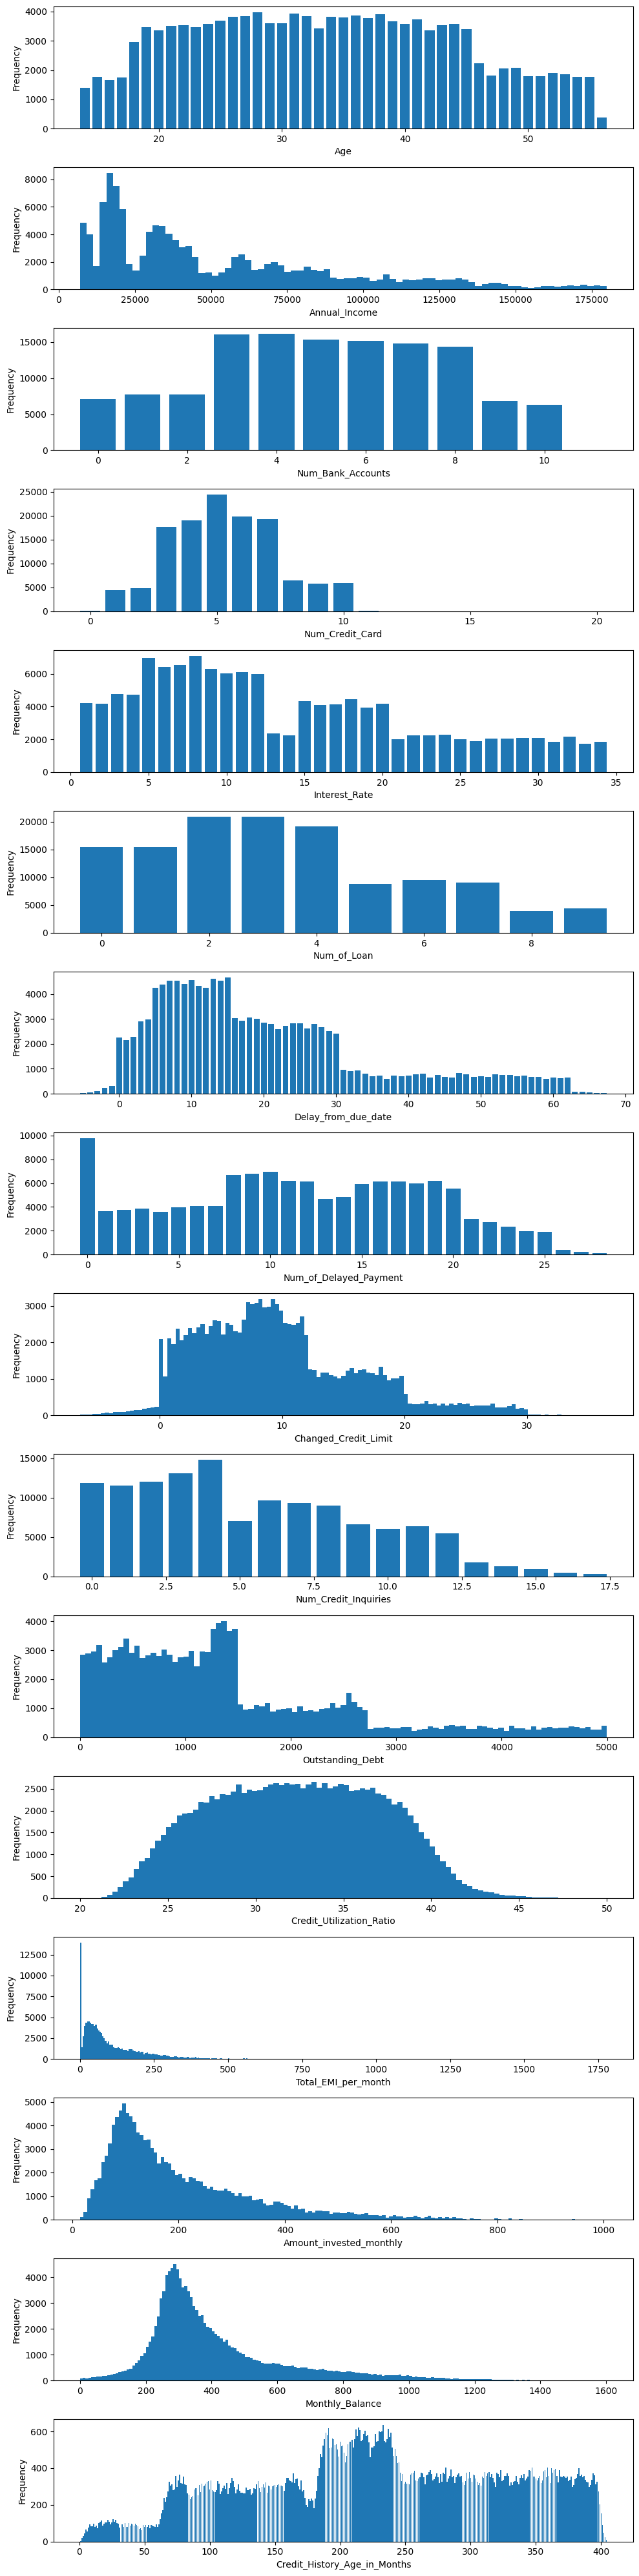

In [96]:
plt.figure(figsize=[10,40])
cols = list(X_train.columns)
for i in range(16):
    plt.subplot(16, 1, i + 1)
    if np.issubdtype(X_train[cols[i]].dtype, np.integer):
        counts = X_train[cols[i]].value_counts().sort_index()
        plt.bar(counts.index, counts.values)
        plt.xlabel(cols[i])
    else:
        nbins = (max(X_train.iloc[:,i]) - min(X_train.iloc[:,i]))/(2 * iqr(X_train.iloc[:,i]) * (len(X_train.iloc[:,i])) ** (-1/3))
        plt.hist(X_train.iloc[:, i], bins=round(nbins))
        plt.xlabel(cols[i])
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


The MinMax scaler is preferred over the Standard scaler in this case because it preserves the original distribution of the data. Since most of the features exhibited a positive skew, the MinMax scaler can effectively map the values to a predefined range (typically between 0 and 1), maintaining the relative relationships and proportions among the data points.

This scaling method is particularly beneficial when working with algorithms that rely on the magnitude of the features, such as distance-based algorithms or neural networks. On the other hand, the Standard scaler transforms the data to have zero mean and unit variance, which may alter the original distribution and affect the interpretation of the results, especially in cases where preserving the original data distribution is important.

In [97]:
scaler = MinMaxScaler()
cols = list(X_train.columns.values[0:16])
X_train_scaled = X_train.copy()
X_train_scaled[cols] = scaler.fit_transform(X_train[cols])
X_test_scaled = X_test.copy()
X_test_scaled[cols] = scaler.transform(X_test[cols])
X_train_scaled = pd.DataFrame(X_train_scaled, columns= X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns= X_test.columns)

## The Naïve Model 

This model generates random predictions for the classification problem and then evaluates the accuracy and RMSE of these predictions by comparing them to the true labels. It serves as a baseline for evaluating the performance of more sophisticated models.

In [98]:
naive = np.random.randint(0, 2, y_test.shape)
naive_accuracy = accuracy_score(y_test, naive)
naive_rmse = np.sqrt(mean_squared_error(y_test, naive))
print(f'Accuracy = {naive_accuracy}')
print(f'RMSE = {naive_rmse}')

Accuracy = 0.3343363109230528
RMSE = 1.0726471976640954


## Random Forest regression

The Random Forest model produces a good model for credit classification with an accuracy of 86.99% and a RMSE of 0.4088. An optimised Random Forest model was obtained using GridSearch. The chosen fine-tuned model has no bootstrapping of data, max features 5 and max estimators 30 has a higher accuracy of 87.2% and a lower RMSE of 0.3964 as desired.

The model identifies the following features as important predictors in the respective order-interest rate, outstanding debt, delay from due date, credit history age in months, credit mix, number of credit inquiries, changed credit limit, monthly balance, annual income, credit utilization ratio.

In [99]:
RNF = RandomForestClassifier(random_state=42)
RNF.fit(X_train_scaled, y_train)
y_hat = RNF.predict(X_test_scaled)
rnf_accuracy = accuracy_score(y_test, y_hat)
rnf_rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print(f'Accuracy = {rnf_accuracy}')
print(f'RMSE = {rnf_rmse}')
print(f'Classification report:\n{classification_report(y_test, y_hat)}')

Accuracy = 0.8699576868829337
RMSE = 0.40888118932810513
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     10715
           1       0.86      0.77      0.81     10617
           2       0.87      0.94      0.91     10573

    accuracy                           0.87     31905
   macro avg       0.87      0.87      0.87     31905
weighted avg       0.87      0.87      0.87     31905



In [100]:
param_grid = {'n_estimators': [3, 10, 30],
              'max_features': [5, 10, 15, 20],
              'bootstrap': [True, False]}
grid_forest = GridSearchCV(RNF, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_forest.fit(X_train_scaled, y_train)
print(f'Best parameters: {grid_forest.best_params_}')

feature_importances = grid_forest.best_estimator_.feature_importances_
print(sorted(zip(feature_importances, X_train.columns), reverse=True))
final_rnf_model = grid_forest.best_estimator_

final_rnf_predictions = final_rnf_model.predict(X_test_scaled)
final_rnf_accuracy = accuracy_score(y_test, final_rnf_predictions)
final_rnf_rmse = np.sqrt(mean_squared_error(y_test, final_rnf_predictions))
print(f'Accuracy = {final_rnf_accuracy}')
print(f'RMSE = {final_rnf_rmse}')

Best parameters: {'bootstrap': False, 'max_features': 5, 'n_estimators': 30}
[(0.09025663727360365, 'Interest_Rate'), (0.08833377411158969, 'Outstanding_Debt'), (0.06948328316371134, 'Delay_from_due_date'), (0.06188028403159751, 'Credit_History_Age_in_Months'), (0.04467384749646759, 'Standard'), (0.044031545517140155, 'Num_Credit_Inquiries'), (0.0431030675938813, 'Changed_Credit_Limit'), (0.04062761931091156, 'Monthly_Balance'), (0.040547168942379516, 'Good'), (0.036964067428708204, 'Annual_Income'), (0.03610616229742555, 'Credit_Utilization_Ratio'), (0.033720241212935285, 'Num_Credit_Card'), (0.03326879804220886, 'Amount_invested_monthly'), (0.03281203287619445, 'Num_of_Delayed_Payment'), (0.03176940087076319, 'Age'), (0.0314478050712613, 'Total_EMI_per_month'), (0.03126619178618517, 'Num_Bank_Accounts'), (0.026292206793086317, 'Yes'), (0.021509515083795974, 'Num_of_Loan'), (0.014772966751563811, 'No'), (0.010113949087472169, 'Bad'), (0.009325445397153697, 'LowspentSmallvaluepayments'

## Decision Tree

Initially, the standard decision tree model, using maximum features 20, maximum depth, and random state of 42 demonstrated an accuracy of 77.73% and a RMSE (Root Mean Squared Error) of 0.5809. However, through the process of fine-tuning the model using GridSearch, an optimized model was identified. This refined decision tree model achieved an accuracy of 78.74% and a RMSE of 0.5635.

Based on the best model from the GridSearch, the top 10 features are as follows:

Payment of minimum amount, credit mix, interest rate, outstanding debt, credit history age in months, delay from due date, annual income, changed credit limit, amount invested monthly, total EMI per month.

In [101]:
dt = DecisionTreeClassifier(max_features=20, max_depth=15, random_state=42)
dt.fit(X_train_scaled, y_train)
dt_y_hat = dt.predict(X_test_scaled)
dt_accuracy = accuracy_score(y_test, dt_y_hat)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_y_hat))
print(f'Accuracy = {dt_accuracy}')
print(f'RMSE = {dt_rmse}')
print(f'Classification report:\n{classification_report(y_test, dt_y_hat)}')

Accuracy = 0.777276288982918
RMSE = 0.5808952339632746
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     10715
           1       0.74      0.69      0.71     10617
           2       0.79      0.85      0.82     10573

    accuracy                           0.78     31905
   macro avg       0.78      0.78      0.78     31905
weighted avg       0.78      0.78      0.78     31905



In [102]:
param_grid = {'max_features': [10, 15, 20, 25],
              'max_depth': [5, 10, 15, 20]}
grid_dt = GridSearchCV(dt, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_dt.fit(X_train_scaled, y_train)
print(f'Best parameters: {grid_dt.best_params_}')

feature_importances = grid_dt.best_estimator_.feature_importances_
print(sorted(zip(feature_importances, X_train.columns), reverse=True))
final_dt_model = grid_dt.best_estimator_

final_dt_predictions = final_dt_model.predict(X_test_scaled)
final_dt_accuracy = accuracy_score(y_test, final_dt_predictions)
final_dt_rmse = np.sqrt(mean_squared_error(y_test, final_dt_predictions))
print(f'Accuracy = {final_dt_accuracy}')
print(f'RMSE = {final_dt_rmse}')

Best parameters: {'max_depth': 20, 'max_features': 20}
[(0.1796295572081746, 'No'), (0.09415184530058616, 'Good'), (0.09402673574324481, 'Interest_Rate'), (0.08235284537921804, 'Outstanding_Debt'), (0.07079538119701424, 'Credit_History_Age_in_Months'), (0.03440942178331397, 'Delay_from_due_date'), (0.032044560262849846, 'Annual_Income'), (0.031619436615163796, 'Changed_Credit_Limit'), (0.02949070534361487, 'Standard'), (0.02756362875765923, 'Amount_invested_monthly'), (0.025965127062121656, 'Total_EMI_per_month'), (0.0238213621894478, 'Num_Credit_Card'), (0.022994935549536657, 'Monthly_Balance'), (0.02133146637308227, 'Num_Bank_Accounts'), (0.02109078468436296, 'Num_of_Delayed_Payment'), (0.020867495404136877, 'Age'), (0.02013700481695196, 'Credit_Utilization_Ratio'), (0.0189392466785202, 'Yes'), (0.01555766792357304, 'HighspentMediumvaluepayments'), (0.014841922159031372, 'Num_Credit_Inquiries'), (0.013058865092204103, 'HighspentSmallvaluepayments'), (0.011889571243323887, 'LowspentMe

Since Random Forest model uses multiple decision trees to obtain a model for the classification problem, it is appropriate to compare the results from this model with those obtained from Decision tree.

Both models highlight ‘Interest_Rate', 'Outstanding_Debt', 'Delay_from_due_date' and 'Credit_History_Age_in_Months' 'Num_Credit_Inquiries', 'Credit_Mix', and 'Changed_Credit_Limit’ as notable features for credit score classification.

In the decision tree model, the feature 'No' (representing the payment of the minimum amount) is assigned significant importance, ranking as the most influential feature. On the other hand, in the Random Forest model, credit mix has been identified as a more significant factor, receiving higher importance.

In the decision tree model, the top 10 features that hold importance include variables such as monthly investment amount, and number of credit cards. However, in the random forest model, these features have been replaced by the inclusion of monthly balance as one of the influential factors.

Overall, although there are similarities in the key features between the two models, there are also some differences. The decision tree model seems to focus more on specific features like 'No' and 'Amount_invested_monthly', while the random forest model places higher emphasis on 'Good' and 'Monthly_Balance'. These variations in feature importance rankings can arise from the inherent differences between the models and their training processes.

Random forests are considered "black box" models. However, it still provides some level of interpretability. You can interpret the importance of each feature in the model, which can help identify key factors that influence credit scoring decisions.

Random forests can be sensitive to noisy or irrelevant features in the dataset, which can introduce randomness and decrease overall predictive performance.
​
Selecting appropriate hyperparameters is crucial for optimal performance. However, due to limited computational power we are only able to test limited combinations of estimators and features.

## K Neighbours

The K Neighbours algorithm initially had the default value for the parameter 'n_neighbors' which resulted in a model with an accuracy of 81.57% and a RMSE value of 0.5192. However, after fine-tuning the model using GridSearch, its performance improved. The refined model achieved a slightly higher accuracy of 82.59% and a comparatively lower RMSE of 0.4955 with the parameter 'n_neighbbors' having an optimal value of 3.

In [103]:
kn = KNeighborsClassifier()
kn.fit(X_train_scaled, y_train)
kn_y_pred = kn.predict(X_test_scaled)
kn_cm = confusion_matrix(y_test,kn_y_pred)
kn_accuracy = accuracy_score(y_test,kn_y_pred)
kn_rmse = np.sqrt(mean_squared_error(y_test, kn_y_pred))
print(f"Accuracy = {kn_accuracy}")
print(f'RMSE = {kn_rmse}')
print(f"Confusion matrix:\n{kn_cm}")

Accuracy = 0.8157028678890456
RMSE = 0.5192124519758641
Confusion matrix:
[[9141  977  597]
 [1958 7345 1314]
 [ 310  724 9539]]


In [104]:
param_grid = {'n_neighbors': [3, 5]}
grid_knn = GridSearchCV(kn, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_knn.fit(X_train_scaled, y_train)
print(f'Best parameters: {grid_knn.best_params_}')
cvres = grid_knn.cv_results_

final_knn_model = grid_knn.best_estimator_

final_knn_predictions = final_knn_model.predict(X_test_scaled)
final_knn_accuracy = accuracy_score(y_test, final_knn_predictions)
final_knn_rmse = np.sqrt(mean_squared_error(y_test, final_knn_predictions))
print(f'Accuracy = {final_knn_accuracy}')
print(f'RMSE = {final_knn_rmse}')

Best parameters: {'n_neighbors': 3}
Accuracy = 0.8259207020843128
RMSE = 0.49552139326491257


## Elastic Net Regression

The Elastic Net classifier initially had values for 'alpha' and 'l1_ratio' set to 0.1 and 0.5 respectively which gave a RMSE of 0.6662. After, fine-tuning the model using GridSearch the optimised model gave a lower RMSE of 0.6433 with parameters 'alpha' and 'l1_ration' taking on optimal values of 0.1 and 0.2 respectively.

In [105]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train_scaled,y_train)
elastic_pred = elastic_net.predict(X_test_scaled)
elastic_rmse = np.sqrt(mean_squared_error(y_test, elastic_pred))
print(f'RMSE = {elastic_rmse}')

RMSE = 0.6661530669248653


The top 10 features based on this model are 'Interest_Rate', 'Payment_of_Minimum_Amount', 'Delay_from_due_date', 'Credit_History_age_in_months', 'Credit_Mix', 'Num_Credit_Inquires', 'Payment_Behaviour', 'Num_of_Loan', 'Num_Bank_Accounts', and 'Outstanding_Debt'.

In [106]:
param_grid = {'alpha': [0.1, 0.5, 1.0],
              'l1_ratio': [0.2, 0.5, 0.8]}
grid_elastic = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_elastic.fit(X_train_scaled, y_train)
print(f'Best parameters: {grid_elastic.best_params_}')
cvres = grid_elastic.cv_results_

final_elastic_model = grid_elastic.best_estimator_
feature_importances = pd.Series(data=np.abs(final_elastic_model.coef_), index=X_train_scaled.columns)
print(feature_importances.sort_values(ascending=False))

final_elastic_predictions = final_elastic_model.predict(X_test_scaled)
final_elastic_rmse = np.sqrt(mean_squared_error(y_test, final_elastic_predictions))
print(f'RMSE = {final_elastic_rmse}')

Best parameters: {'alpha': 0.1, 'l1_ratio': 0.2}
Good                            0.285776
Interest_Rate                   0.209333
Bad                             0.182955
No                              0.151554
Yes                             0.119962
Delay_from_due_date             0.097452
Num_Credit_Inquiries            0.086600
Credit_History_Age_in_Months    0.056194
Num_of_Loan                     0.045181
Num_Bank_Accounts               0.035531
Outstanding_Debt                0.027116
LowspentSmallvaluepayments      0.019135
Auto Loan                       0.009544
Personal Loan                   0.004974
Debt Consolidation Loan         0.001351
Standard                        0.000000
HighspentLargevaluepayments     0.000000
HighspentMediumvaluepayments    0.000000
HighspentSmallvaluepayments     0.000000
LowspentMediumvaluepayments     0.000000
LowspentLargevaluepayments      0.000000
Age                             0.000000
Credit-Builder Loan             0.000000
Teacher 

In [107]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state = 42)
print(f'''Train: \nX = {X_train.shape}\ny = {y_train.shape}\n{y_train.value_counts()}\n
Test: \nX = {X_test.shape}\ny = {y_test.shape}\n{y_test.value_counts()}\n
Validation: \nX = {X_valid.shape}\ny = {y_valid.shape}\n{y_valid.value_counts()}''')

Train: 
X = (102093, 52)
y = (102093,)
Credit_Score
2    34087
1    34050
0    33956
Name: count, dtype: int64

Test: 
X = (31905, 52)
y = (31905,)
Credit_Score
0    10715
1    10617
2    10573
Name: count, dtype: int64

Validation: 
X = (25524, 52)
y = (25524,)
Credit_Score
2    8514
1    8507
0    8503
Name: count, dtype: int64


In [108]:
train_binary_columns = X_train.iloc[:, 16:]
valid_binary_columns = X_valid.iloc[:, 16:]
test_binary_columns = X_test.iloc[:, 16:]
train_non_binary_columns = X_train.iloc[:,:16]
valid_non_binary_columns = X_valid.iloc[:, :16]
test_non_binary_columns = X_test.iloc[:, :16]

## Neural networks

Initially, the standard neural network model, demonstrate an accuracy of 33.28% and a RMSE (Root Mean Squared Error) of 0.8169. However, through the process of fine-tuning the model using keras_tuner, an optimized model was identified. This refined model achieved an accuracy of 48.98% and a lower RMSE of 0.5977.

In [109]:
tf.random.set_seed(42)

norm_layer = keras.layers.Normalization()

X_train = tf.concat([norm_layer(train_non_binary_columns), train_binary_columns], axis=1)

X_valid = tf.concat([norm_layer(valid_non_binary_columns), valid_binary_columns], axis=1)

X_test = tf.concat([norm_layer(test_non_binary_columns), test_binary_columns], axis=1)

model = keras.Sequential([keras.Input(shape=X_train.shape[1:]), 
                          keras.layers.Dense(50, activation='relu'), 
                          keras.layers.Dense(50, activation='relu'), 
                          keras.layers.Dense(50, activation='relu'), 
                          keras.layers.Dense(1)])
optim = keras.optimizers.Adam()
model.compile(optimizer=optim, loss='mse', metrics=['RootMeanSquaredError', 'accuracy'])

model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

nn_scores = model.evaluate(X_test, y_test)
print(f'RMSE = {nn_scores[1]}')
print(f'Accuracy = {nn_scores[2]}')
print(model.metrics_names)

Epoch 1/20
3191/3191 [==============================] - 12s 3ms/step - loss: 4360.9771 - root_mean_squared_error: 66.0377 - accuracy: 0.3641 - val_loss: 6.5984 - val_root_mean_squared_error: 2.5687 - val_accuracy: 0.3672
Epoch 2/20
3191/3191 [==============================] - 9s 3ms/step - loss: 377.8171 - root_mean_squared_error: 19.4375 - accuracy: 0.3645 - val_loss: 0.8366 - val_root_mean_squared_error: 0.9147 - val_accuracy: 0.4227
Epoch 3/20
3191/3191 [==============================] - 9s 3ms/step - loss: 234.3062 - root_mean_squared_error: 15.3071 - accuracy: 0.3748 - val_loss: 186.2600 - val_root_mean_squared_error: 13.6477 - val_accuracy: 0.3331
Epoch 4/20
3191/3191 [==============================] - 10s 3ms/step - loss: 100.9104 - root_mean_squared_error: 10.0454 - accuracy: 0.3625 - val_loss: 1.5963 - val_root_mean_squared_error: 1.2634 - val_accuracy: 0.3832
Epoch 5/20
3191/3191 [==============================] - 10s 3ms/step - loss: 47.2334 - root_mean_squared_error: 6.8727

In [110]:
def build_model(hp):
    n_hidden = hp.Int('n_hidden', min_value=2, max_value=9)
    n_neurons = hp.Int('n_neurons', min_value=16, max_value=256, step=16)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer_choice = hp.Choice('optimizer_choice', values=['sgd', 'adam'])
    
    model = keras.models.Sequential()
    
    model.add(keras.Input(shape=X_train.shape[1:]))
    
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    
    model.add(keras.layers.Dense(1))
    
    if optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, clipvalue=1.0)
    else:
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['RootMeanSquaredError', 'accuracy'])
    return model


tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_root_mean_squared_error', direction='min'),
    overwrite=True,
    seed=42
)

tuner.search(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Trial 10 Complete [00h 03m 56s]
val_root_mean_squared_error: 0.5983656644821167

Best val_root_mean_squared_error So Far: 0.5983656644821167
Total elapsed time: 00h 40m 16s
INFO:tensorflow:Oracle triggered exit


In [111]:
top_models = tuner.get_best_models(num_models=3)
best_model = top_models[0]

nn_opt_scores = best_model.evaluate(X_test, y_test)
print(f'RMSE = {nn_opt_scores[1]}')
print(f'Accuracy = {nn_opt_scores[2]}')
print(best_model.metrics_names)

998/998 [==============================] - 3s 3ms/step - loss: 0.3573 - root_mean_squared_error: 0.5977 - accuracy: 0.4898
RMSE = 0.5977405309677124
Accuracy = 0.48979783058166504
['loss', 'root_mean_squared_error', 'accuracy']


Through our analysis of the key features across the models that we tested; we have identified key factors that contribute to a higher credit score. These factors include:

**Payment History**: Consistently making on-time payments for credit cards, loans.

**Credit History Length**: Maintaining a longer credit history demonstrates stability.

**Credit Utilization**: Keeping credit card balances low compared to credit limits.

**Credit Mix**: Having a diverse range of credit types, such as credit cards, mortgages, and instalment loans.

**New Credit inquires**: Avoiding excessive credit inquiries, as it may indicate financial instability.

**Interest Rate**: Can have a significant impact on an individual's ability to manage their debts effectively. High interest rates can lead to larger debt burdens and make it more challenging to make timely payments, increasing the risk of delinquency and negatively affecting creditworthiness over time.

**Outstanding Debt**: A higher outstanding debt can indicate a greater risk of default or financial stress, potentially leading to a lower credit score. Maintaining a lower debt-to-credit ratio is favourable for credit scoring.

**Delays in Payments**: Even a single late payment can have a detrimental effect, although the severity of the impact may vary depending on the scoring model and the specific circumstances. More recent late payments are considered more significant than older ones however since our data is only for a period of 6 months, we assume equal weight to all the months.

**Number of Delays in Payments**: Consistently making late payments or having a higher frequency of delayed payments can be a red flag for lenders and negatively affect credit scoring. It indicates a pattern of financial irresponsibility or difficulty in managing debts, which may increase the perceived risk associated with lending to that individual.

It is important to note that the severity and duration can also influence the impact of late payments on credit scoring. For example, a payment that is only a few days late may have a lesser impact than one that is significantly overdue or results in debt collection actions.

The results of the above models are summarised in the table below

In [113]:
models = ['Naive','Random Forest','Optimised Random forest','Decision Tree','Optimised Decision Tree','KNN','Optimised KNN','Elastic Net Regression','Optimised Elastic Net Regression','Neural network (3H50N)','Optimised Neural Network']
cols = ['Accuracy','RMSE']
Data_table = pd.DataFrame(data=0, index= models, columns= cols)
Data_table['Accuracy'] = [naive_accuracy, rnf_accuracy, final_rnf_accuracy, dt_accuracy, final_dt_accuracy, kn_accuracy, 
                        final_knn_accuracy, np.NaN, np.NaN, nn_scores[2], nn_opt_scores[2]]
Data_table['RMSE'] = [naive_rmse, rnf_rmse, final_rnf_rmse, dt_rmse, final_dt_rmse, kn_rmse, final_knn_rmse, elastic_rmse,
                      final_elastic_rmse, nn_scores[1], nn_opt_scores[1]]
Data_table = Data_table.sort_values('RMSE', ascending=True)
print(Data_table)

                                  Accuracy      RMSE
Optimised Random forest           0.871901  0.396427
Random Forest                     0.869958  0.408881
Optimised KNN                     0.825921  0.495521
KNN                               0.815703  0.519212
Optimised Decision Tree           0.787337  0.563476
Decision Tree                     0.777276  0.580895
Optimised Neural Network          0.489798  0.597741
Optimised Elastic Net Regression       NaN  0.643274
Elastic Net Regression                 NaN  0.666153
Neural network (3H50N)            0.332769  0.816878
Naive                             0.334336  1.072647


In [115]:
df = pd.DataFrame(sorted(zip(grid_forest.best_estimator_.feature_importances_, X_train_scaled.columns), reverse=True), columns=['Score', 'Label'])
print(df)

       Score                         Label
0   0.090257                 Interest_Rate
1   0.088334              Outstanding_Debt
2   0.069483           Delay_from_due_date
3   0.061880  Credit_History_Age_in_Months
4   0.044674                      Standard
5   0.044032          Num_Credit_Inquiries
6   0.043103          Changed_Credit_Limit
7   0.040628               Monthly_Balance
8   0.040547                          Good
9   0.036964                 Annual_Income
10  0.036106      Credit_Utilization_Ratio
11  0.033720               Num_Credit_Card
12  0.033269       Amount_invested_monthly
13  0.032812        Num_of_Delayed_Payment
14  0.031769                           Age
15  0.031448           Total_EMI_per_month
16  0.031266             Num_Bank_Accounts
17  0.026292                           Yes
18  0.021510                   Num_of_Loan
19  0.014773                            No
20  0.010114                           Bad
21  0.009325    LowspentSmallvaluepayments
22  0.00747

# Conclusion

From the analysis of the data and the insights from the model, we have identified that interest rate, outstanding debt, delays, credit history, credit mix, credit inquiries, credit limits, income and credit utilization ratio are the primary drivers of an individual’s credit score and through responsible behaviour any individual can upgrade their credit ratings.

We have also identified that occupation, payment behaviour and type of loan do not provide much predictive power and may only make the data points more sparse that can potentially affect the results of the models. This is also because the model gives a higher priority to salary derived from occupation, the existence of a good credit mix rather than the exact types of loans taken and the amount and duration of the delay rather than the plain description of the kind of payments the individual does on a regular basis.

The adoption of machine learning algorithms for credit score classification is increasingly widespread due to their effectiveness and advantages. One key benefit is their ability to handle large and complex datasets, allowing for more accurate predictions compared to traditional methods. Traditional credit scoring methods have been criticized for perpetuating discrimination and bias, particularly against marginalized groups. Machine learning algorithms can analyse various factors like credit history, income, and debt levels, while minimizing bias and discrimination by focusing on objective variables rather than personal or potentially discriminatory factors such as race, gender, or ethnicity. These models can also adapt and improve over time by incorporating new data and adjusting to changing economic conditions and evolving consumer behaviours. Automated credit score classification systems save time and resources for lenders, enabling faster and more efficient services. However, machine learning algorithms require high-quality and diverse data to ensure accuracy, and the interpretability of these models can be challenging.

# References

Credit score classification (Kaggle): [1](https://www.kaggle.com/datasets/parisrohan/credit-score-classification?resource=download)